In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


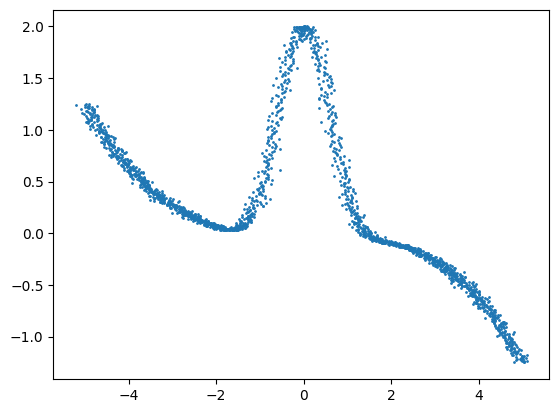

In [3]:
# 비선형회귀 1차원 문제설정
xs = np.linspace(-5,5,2000)
ys = []
for idx,x in enumerate(xs):
    xs[idx] = x+0.1*np.random.normal()
    y_value = -0.01*x**3+2*np.cos(x)*np.exp(-x**2)
    ys.append(y_value)
ys = np.array(ys)
plt.plot(xs,ys,'o',markersize=1)

In [4]:
# 훈련,검증,테스트 데이터 분리
test_idx = np.random.randint(0,len(xs),int(0.2*len(xs)))
#print(test_idx)
x_test = xs[test_idx]
y_test = ys[test_idx]

mask = np.ones(len(xs),dtype=bool)
mask[test_idx] = False
xs = xs[mask,...]
ys = ys[mask,...]

validation_idx = np.random.randint(0,len(xs),int(0.2*len(xs)))
x_valid = xs[validation_idx]
y_valid = ys[validation_idx]

mask = np.ones(len(xs),dtype=bool)
mask[validation_idx]=False
x_train = xs[mask,...]
y_train = ys[mask,...]

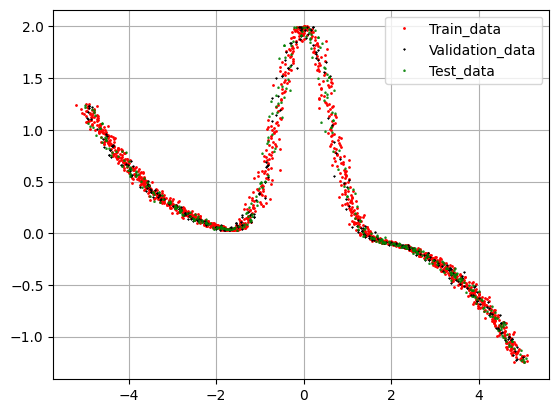

In [5]:
plt.plot(x_train,y_train,'ro',markersize=1,label='Train_data')
plt.plot(x_valid,y_valid,'k*',markersize=1,label='Validation_data')
plt.plot(x_test,y_test,'g^',markersize=1,label='Test_data')
plt.grid()
plt.legend()

In [6]:
# 커스텀 데이터셋 제작
class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.Tensor(x).to(device).view(-1,1)
        self.y = torch.Tensor(y).to(device).view(-1,1)
    
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    
    def __len__(self):
        return len(self.x)

In [7]:
# 정규화
x_min,x_max = x_train.min(),x_train.max()
y_min,y_max = y_train.min(),y_train.max()
def normalization(x,y):
    '''
    목적: 정규화 함수
    입력: x,y
    출력: 정규화된 x,y
    '''
    x = (x-x_min)/(x_max-x_min)
    y = (y-y_min)/(y_max-y_min)
    return x,y

def unnormalization(x,y):
    '''
    목적: 정규화 복원함수
    입력: x,y
    출력: 정규화 복원된 x,y
    '''
    x = x*(x_max-x_min)+x_min
    y = y*(y_max-y_min)+y_min
    return x,y

In [8]:
# 훈련-검증 데이터 정규화
x_train,y_train = normalization(x_train,y_train)
x_valid,y_valid = normalization(x_valid,y_valid)

In [9]:
print(x_train.min(),x_train.max())
print(y_train.min(),y_train.max())
print(x_valid.min(),x_valid.max())
print(y_valid.min(),y_valid.max())

0.0 1.0
0.0 1.0
0.024531054507191494 0.9921893205578557
0.006885083125072034 0.999861420721495


In [10]:
# 데이터셋 및 데이터로더 정의
train_dataset = MyDataset(x_train,y_train)
valid_dataset = MyDataset(x_valid,y_valid)

train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_dataloader = DataLoader(valid_dataset,batch_size=32,shuffle=False)

In [11]:
# 신경망 제작
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()
        self.lin1 = nn.Linear(1,32)
        self.lin2 = nn.Linear(32,32)
        self.lin3 = nn.Linear(32,32)
        self.lin4 = nn.Linear(32,1)
        
    def forward(self,x):
        x = F.elu(self.lin1(x))
        x = F.elu(self.lin2(x))
        x = F.elu(self.lin3(x))
        x = self.lin4(x)
        return x

In [12]:
model = MyModel().to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-04,weight_decay=1e-12)

In [13]:
criterion = nn.MSELoss()

In [14]:
for epoch in range(2000):
    train_loss, valid_loss = 0, 0
    cnt_train, cnt_valid = 0, 0
    for x,y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        y_infer = model(x)
        loss = criterion(y_infer,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        cnt_train += 1
    
    with torch.no_grad():
        for x,y in valid_dataloader:
            x = x.to(device)
            y = y.to(device)
            y_infer = model(x)
            loss = criterion(y_infer,y)
            valid_loss += loss.item()
            cnt_valid += 1
    if epoch % 100 == 0:
        print(f'{epoch} Epoch 학습정보')
        print(f'Loss: {train_loss/cnt_train:.4f}(Train_data),  {valid_loss/cnt_valid:.4f}(Validation_data)')

0 Epoch 학습정보
Loss: 0.3491(Train_data),  0.2413(Validation_data)
100 Epoch 학습정보
Loss: 0.0232(Train_data),  0.0239(Validation_data)
200 Epoch 학습정보
Loss: 0.0212(Train_data),  0.0221(Validation_data)
300 Epoch 학습정보
Loss: 0.0112(Train_data),  0.0126(Validation_data)
400 Epoch 학습정보
Loss: 0.0042(Train_data),  0.0047(Validation_data)
500 Epoch 학습정보
Loss: 0.0020(Train_data),  0.0021(Validation_data)
600 Epoch 학습정보
Loss: 0.0010(Train_data),  0.0010(Validation_data)
700 Epoch 학습정보
Loss: 0.0008(Train_data),  0.0008(Validation_data)
800 Epoch 학습정보
Loss: 0.0008(Train_data),  0.0007(Validation_data)
900 Epoch 학습정보
Loss: 0.0008(Train_data),  0.0008(Validation_data)
1000 Epoch 학습정보
Loss: 0.0008(Train_data),  0.0008(Validation_data)
1100 Epoch 학습정보
Loss: 0.0008(Train_data),  0.0007(Validation_data)
1200 Epoch 학습정보
Loss: 0.0008(Train_data),  0.0007(Validation_data)
1300 Epoch 학습정보
Loss: 0.0008(Train_data),  0.0007(Validation_data)
1400 Epoch 학습정보
Loss: 0.0008(Train_data),  0.0007(Validation_data)
1500 Ep

In [15]:
# 학습 종료후 데이터 시각화
x_train,y_train = unnormalization(x_train,y_train)
x_test,y_test = normalization(x_test,y_test)

In [16]:
x_test_torch = torch.Tensor(x_test).view(-1,1)
y_test_torch = torch.Tensor(y_test).view(-1,1)
y_test_infer = model(x_test_torch)
loss = criterion(y_test_infer,y_test_torch).item()
print(f'테스트 데이터셋 L2_error: {loss}')

테스트 데이터셋 L2_error: 0.0010378377046436071


In [17]:
x_infer = torch.linspace(-5,5,100).view(-1,1)
# x -> normalization
x_infer = (x_infer-x_train.min())/(x_train.max()-x_train.min())
y_infer = model(x_infer)
x_infer = x_infer.detach().cpu().numpy().reshape(-1,)
y_infer = y_infer.detach().cpu().numpy().reshape(-1,)
x_infer,y_infer = unnormalization(x_infer,y_infer)

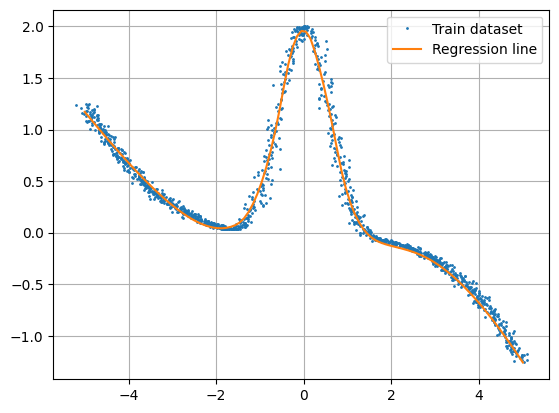

In [20]:
plt.plot(x_train,y_train,'o',markersize=1,label='Train dataset')
plt.plot(x_infer,y_infer,'-',markersize=1,label='Regression line')
plt.grid()
plt.legend()